In [15]:
import os
import numpy as np
from numpy import load, savez_compressed,asarray
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow import keras
from tensorflow.keras import layers, Model,optimizers
from sklearn.model_selection import train_test_split


In [16]:
# Image loading and preprocessing
def load_images(src_path, tar_path, size=(256, 256), max_num_files = 10000):
    src_list, tar_list = list(), list()

    # Get sorted lists of filenames for both source and target folders
    src_filenames = sorted(os.listdir(src_path))
    tar_filenames = sorted(os.listdir(tar_path))

    src_filenames = src_filenames[:max_num_files]
    tar_filenames=tar_filenames[:max_num_files]

    # Ensure both folders have the same filenames
    if src_filenames != tar_filenames:
        raise ValueError("Source and target folders do not have matching filenames.")
      
    # Load and preprocess source images
    for filename in src_filenames:
        # Load and resize the image
        src_pixels = load_img(os.path.join(src_path, filename), target_size=size)
        # Convert to numpy array
        src_pixels = img_to_array(src_pixels)
        src_list.append(src_pixels)

    # Load and preprocess target images
    for filename in tar_filenames:
        # Load and resize the image
        tar_pixels = load_img(os.path.join(tar_path, filename), target_size=size)
        # Convert to numpy array
        tar_pixels = img_to_array(tar_pixels)
        tar_list.append(tar_pixels)

    return [asarray(src_list), asarray(tar_list)]

In [17]:
def build_generator(image_shape):
    def encoder_block(inputs, filters, apply_batchnorm=True):
        x = layers.Conv2D(filters, 4, strides=2, padding='same', kernel_initializer='he_normal')(inputs)
        if apply_batchnorm:
            x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU(alpha=0.2)(x)
        return x

    def decoder_block(inputs, skip_inputs, filters, dropout=True):
        x = layers.Conv2DTranspose(filters, 4, strides=2, padding='same', kernel_initializer='he_normal')(inputs)
        x = layers.BatchNormalization()(x)
        
        if dropout:
            x = layers.Dropout(0.5)(x)
        
        # Ensure skip_inputs matches x shape
        if skip_inputs.shape[1:3] != x.shape[1:3]:
            skip_inputs = layers.Resizing(x.shape[1], x.shape[2])(skip_inputs)
        
        x = layers.Concatenate()([x, skip_inputs])
        x = layers.ReLU()(x)
        return x

    inputs = layers.Input(shape=image_shape)

    # Encoder
    e1 = encoder_block(inputs, 64, apply_batchnorm=False)
    e2 = encoder_block(e1, 128)
    e3 = encoder_block(e2, 256)
    e4 = encoder_block(e3, 512)
    e5 = encoder_block(e4, 512)
    e6 = encoder_block(e5, 512)
    e7 = encoder_block(e6, 512)

    # Bottleneck
    b = layers.Conv2D(512, 4, strides=2, padding='same', activation='relu')(e7)

    # Decoder
    d1 = decoder_block(b, e7, 512)
    d2 = decoder_block(d1, e6, 512)
    d3 = decoder_block(d2, e5, 512)
    d4 = decoder_block(d3, e4, 512, dropout=False)
    d5 = decoder_block(d4, e3, 256, dropout=False)
    d6 = decoder_block(d5, e2, 128, dropout=False)
    d7 = decoder_block(d6, e1, 64, dropout=False)

    # Final layer ensuring output matches input shape
    outputs = layers.Conv2DTranspose(3, 4, strides=2, padding='same', activation='tanh')(d7)
    outputs = layers.Resizing(image_shape[0], image_shape[1])(outputs)

    return Model(inputs=inputs, outputs=outputs)

def build_discriminator(image_shape):
    def conv_block(inputs, filters, kernel_size=4, strides=2, apply_batchnorm=True):
        x = layers.Conv2D(filters, kernel_size, strides=strides, padding='same', kernel_initializer='he_normal')(inputs)
        if apply_batchnorm:
            x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU(alpha=0.2)(x)
        return x

    # Inputs
    source_image = layers.Input(shape=image_shape)
    target_image = layers.Input(shape=image_shape)
    
    # Concatenate images
    x = layers.Concatenate()([source_image, target_image])
    
    # Discriminator layers
    x = conv_block(x, 64, apply_batchnorm=False)
    x = conv_block(x, 128)
    x = conv_block(x, 256)
    x = conv_block(x, 512)
    x = conv_block(x, 512, strides=1)
    
    x = layers.Conv2D(1, 4, padding='same', activation='sigmoid')(x)
    
    return Model([source_image, target_image], x)

class Pix2Pix:
    def __init__(self, image_shape=(256, 256, 3)):  # Updated to 512x 512 images
        self.image_shape = image_shape
        self.discriminator = build_discriminator(image_shape)
        self.generator = build_generator(image_shape)
        self.gan_model = self.build_gan()
        
        self.epoch_history = {
            'generator_loss': [],
            'discriminator_loss_real': [],
            'discriminator_loss_fake': [],
            'discriminator_accuracy_real': [],
            'discriminator_accuracy_fake': []
        }

        self.discriminator.compile(
            optimizer=Adam(learning_rate=0.0003, beta_1=0.5),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

    def build_gan(self):
        # Freeze discriminator during generator training
        self.discriminator.trainable = False

        input_source = layers.Input(shape=self.image_shape)
        generated_image = self.generator(input_source)
        discriminator_output = self.discriminator([input_source, generated_image])

        gan_model = Model(input_source, [discriminator_output, generated_image])
        gan_model.compile(
            optimizer=Adam(learning_rate=0.0003, beta_1=0.5),
            loss=['binary_crossentropy', 'mae'],
            loss_weights=[1, 100]
        )
        return gan_model

    def train(self, train_dataset, epochs=100, batch_size=1):
        # Unpack dataset
        train_sources, train_targets = train_dataset

        # Calculate steps per epoch
        steps_per_epoch = len(train_sources) // batch_size

        for epoch in range(epochs):
            # Reset epoch-level metrics
            epoch_d_loss_real_total = 0
            epoch_d_loss_fake_total = 0
            epoch_d_acc_real_total = 0
            epoch_d_acc_fake_total = 0
            epoch_g_loss_total = 0

            for step in range(steps_per_epoch):
                # Select batch of real images
                start_idx = step * batch_size
                end_idx = start_idx + batch_size
                real_sources = train_sources[start_idx:end_idx]
                real_targets = train_targets[start_idx:end_idx]
                
                # Generate fake images
                fake_targets = self.generator.predict(real_sources)
                
                # Create labels with consistent shape
                real_labels = np.ones((batch_size, 16, 16, 1))  # Updated to match new output size
                fake_labels = np.zeros((batch_size, 16, 16, 1))  # Updated to match new output size
                
                # Train Discriminator
                d_loss_real = self.discriminator.train_on_batch(
                    [real_sources, real_targets], real_labels
                )
                d_loss_fake = self.discriminator.train_on_batch(
                    [real_sources, fake_targets], fake_labels
                )
                
                # Train Generator via GAN model
                g_labels = np.ones((batch_size, 16,16, 1))  # Updated to match new output size
                g_loss = self.gan_model.train_on_batch(
                    real_sources, [g_labels, real_targets]
                )

                print(f'Epoch {epoch+1}, Step {step+1}:')
                print(f'D Loss (Real): {d_loss_real[0]}, D Acc (Real): {d_loss_real[1]}')
                print(f'D Loss (Fake): {d_loss_fake[0]}, D Acc (Fake): {d_loss_fake[1]}')
                print(f'G Loss: {g_loss[0]}')

                # Accumulate epoch-level metrics
                epoch_d_loss_real_total += d_loss_real[0]
                epoch_d_loss_fake_total += d_loss_fake[0]
                epoch_d_acc_real_total += d_loss_real[1]
                epoch_d_acc_fake_total += d_loss_fake[1]
                epoch_g_loss_total += g_loss[0]
                
                # Optional: Save samples 
                if step == 0:  # Save samples every epoch
                    self.save_samples(real_sources, fake_targets, epoch, step)

            # Calculate average metrics for the epoch
            self.epoch_history['discriminator_loss_real'].append(
                epoch_d_loss_real_total / steps_per_epoch
            )
            self.epoch_history['discriminator_loss_fake'].append(
                epoch_d_loss_fake_total / steps_per_epoch
            )
            self.epoch_history['discriminator_accuracy_real'].append(
                epoch_d_acc_real_total / steps_per_epoch
            )
            self.epoch_history['discriminator_accuracy_fake'].append(
                epoch_d_acc_fake_total / steps_per_epoch
            )
            self.epoch_history['generator_loss'].append(
                epoch_g_loss_total / steps_per_epoch
            )


                
    def save_samples(self, sources, generated, epoch, step):
        plt.figure(figsize=(10, 6))
        for i in range(min(3, len(sources))):
            plt.subplot(3, 2, 2*i+1)
            plt.imshow((sources[i] + 1) / 2.0)
            plt.title(f'Source {i+1}')
            plt.subplot(3, 2, 2*i+2)
            plt.imshow((generated[i] + 1) / 2.0)
            plt.title(f'Generated {i+1}')
        plt.tight_layout()
        plt.savefig(f'samples_epoch_{epoch+1}_step_{step}.png')
        plt.close()

    def plot_training_history(self):
        """Plot training history across epochs."""
        plt.figure(figsize=(15, 10))
        
        # Losses subplot
        plt.subplot(2, 1, 1)
        plt.plot(
            self.epoch_history['discriminator_loss_real'], 
            label='Discriminator Loss (Real)'
        )
        plt.plot(
            self.epoch_history['discriminator_loss_fake'], 
            label='Discriminator Loss (Fake)'
        )
        plt.plot(
            self.epoch_history['generator_loss'], 
            label='Generator Loss'
        )
        plt.title('Training Losses')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        
        # Accuracies subplot
        plt.subplot(2, 1, 2)
        plt.plot(
            self.epoch_history['discriminator_accuracy_real'], 
            label='Discriminator Accuracy (Real)'
        )
        plt.plot(
            self.epoch_history['discriminator_accuracy_fake'], 
            label='Discriminator Accuracy (Fake)'
        )
        plt.title('Discriminator Accuracies')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)
        
        plt.tight_layout()
        plt.savefig('training_history.png')
        plt.show()

    def evaluate(self, dataset):
        """Evaluate the generator and discriminator on the test dataset."""
        test_sources, test_targets = dataset
        num_samples = len(test_sources)

        # Generate fake images
        fake_targets = self.generator.predict(test_sources)

        # Calculate MAE for generator
        generator_mae = np.mean(np.abs(fake_targets - test_targets))

        # Evaluate discriminator on real and fake images
        real_labels = np.ones((num_samples, 16,16, 1))  # Updated to match new output size
        fake_labels = np.zeros((num_samples, 16,16, 1))  # Updated to match new output size

        d_loss_real, d_acc_real = self.discriminator.evaluate(
            [test_sources, test_targets], real_labels, verbose=0
        )
        d_loss_fake, d_acc_fake = self.discriminator.evaluate(
            [test_sources, fake_targets], fake_labels, verbose=0
        )

        # GAN loss
        g_labels = np.ones((num_samples, 16,16, 1))  # Updated to match new output size
        g_loss, gan_discriminator_loss, gan_generator_loss = self.gan_model.evaluate(
            test_sources, [g_labels, test_targets], verbose=0
        )

        # Plot training history after evaluation
        self.plot_training_history()

        # Metrics dictionary
        metrics = {
            "Generator MAE": generator_mae,
            "Discriminator Loss (Real)": d_loss_real,
            "Discriminator Loss (Fake)": d_loss_fake,
            "Discriminator Accuracy (Real)": d_acc_real,
            "Discriminator Accuracy (Fake)": d_acc_fake,
            "GAN Loss": g_loss,
        }

        return metrics

In [18]:
original_path = "data/original_scenery_images/"
cartoon_path = "data/cartoon_scenery_images_bis/"

# load dataset
[original_images, cartoon_images] = load_images(original_path, cartoon_path,size=(256,256),max_num_files=1000)
# Normalize images
original_images = (original_images - 127.5) / 127.5
cartoon_images = (cartoon_images - 127.5) / 127.5

In [19]:
filename = 'scenery_bis.npz'
savez_compressed(filename, original_images, cartoon_images)
print('Saved dataset: ', filename)

Saved dataset:  scenery_bis.npz


In [20]:
# data = load('scenery_bis.npz')
# original_images, cartoon_images = data['arr_0'], data['arr_1']

In [21]:
train_original, test_original, train_cartoon, test_cartoon = train_test_split(
    original_images, cartoon_images, test_size=0.2, random_state=42
)

In [22]:
# Define image shape
image_shape = (256,256, 3)

# Create Pix2Pix model
pix2pix = Pix2Pix(image_shape)

# Train the model
pix2pix.train((train_original, train_cartoon), epochs=200, batch_size=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step
Epoch 1, Step 1:
D Loss (Real): 1.0189661979675293, D Acc (Real): 0.05859375
D Loss (Fake): 0.7794313430786133, D Acc (Fake): 0.486328125
G Loss: 42.44758224487305
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
Epoch 1, Step 2:
D Loss (Real): 0.904930830001831, D Acc (Real): 0.3450520932674408
D Loss (Fake): 0.8024924397468567, D Acc (Fake): 0.482421875
G Loss: 42.46062469482422
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
Epoch 1, Step 3:
D Loss (Real): 0.9203178286552429, D Acc (Real): 0.3960937559604645
D Loss (Fake): 0.8484259247779846, D Acc (Fake): 0.4889322817325592
G Loss: 45.091461181640625
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Epoch 1, Step 4:
D Loss (Real): 0.8936846852302551, D Acc (Real): 0.4274553656578064
D Loss (Fake): 0.8519315719604492, D Acc (Fake): 0.4765625
G Loss: 41.8104362487793
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Epoch 1, Step 5:
D Loss (Real): 0.8876731991767883, D Acc (Real): 0.4275173544883728
D Loss (Fake): 0.8570964932441711, D

KeyboardInterrupt: 

4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step


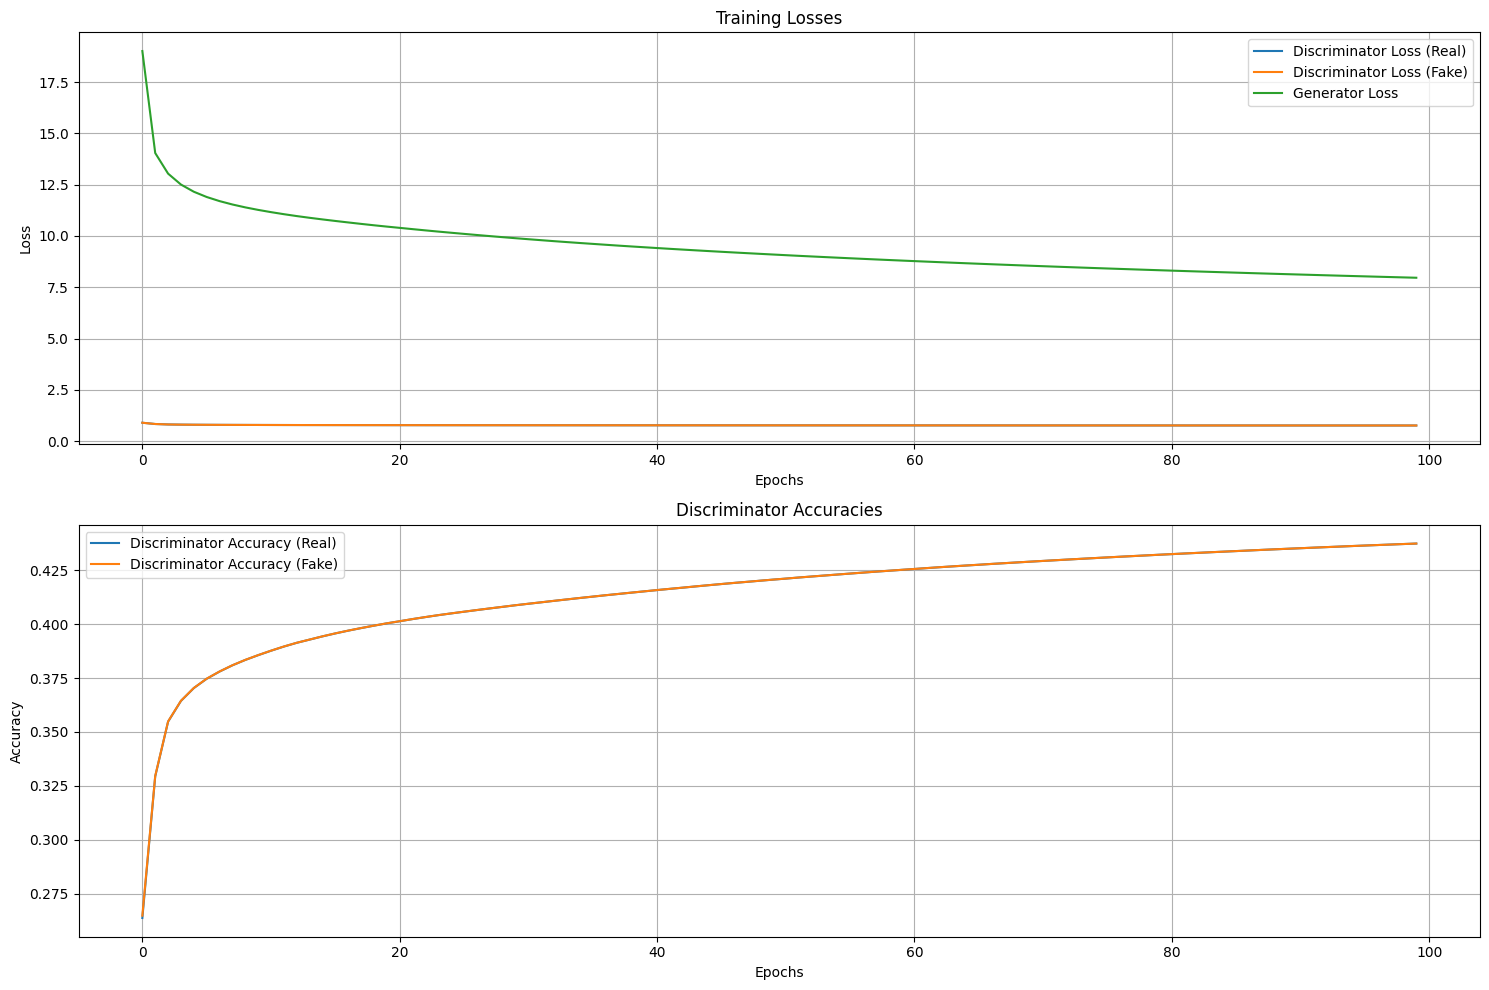

In [ ]:
# Evaluate and visualize the metrics
metrics = pix2pix.evaluate((test_original, test_cartoon))

In [12]:
pix2pix.generator.save('generator_scenery.keras')

In [13]:
generator = tf.keras.models.load_model('generator_scenery.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


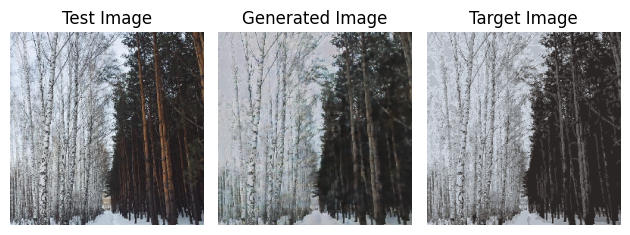

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


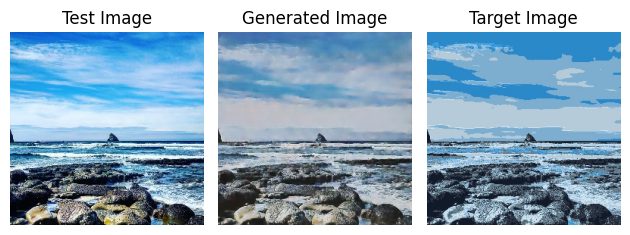

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


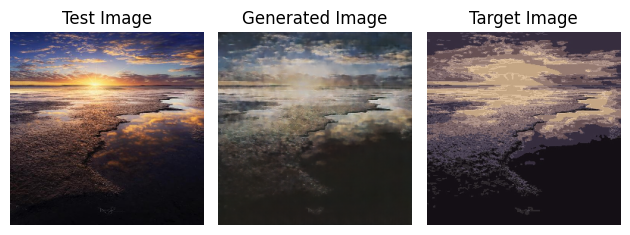

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


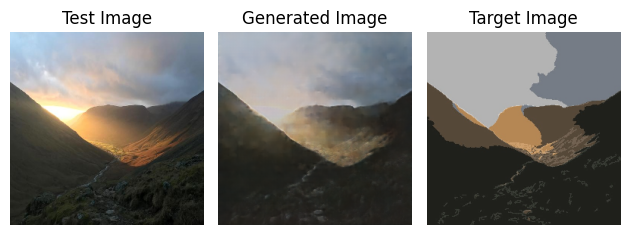

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


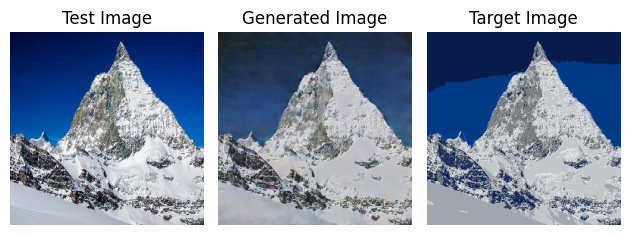

In [ ]:
for i in range(5):
    num = np.random.randint(0, len(test_original))
    test_image = test_original[num]
    target_image = test_cartoon[num]

    test_image = np.expand_dims(test_image, axis=0)
    target_image = np.expand_dims(target_image, axis=0) 
    generated_image = generator.predict(test_image)

    plt.subplot(1, 3, 1)
    plt.imshow((test_image[0] + 1) / 2.0)  # Convert back to [0, 1] for visualization
    plt.title("Test Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow((generated_image[0] + 1) / 2.0)  # Convert back to [0, 1] for visualization
    plt.title("Generated Image")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow((target_image[0] + 1) / 2.0)
    plt.title("Target Image")
    plt.axis('off')

    plt.tight_layout()
    plt.show()